<a href="https://colab.research.google.com/github/vdinni/ProjectCapstone/blob/main/DetectLungColonCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Lung and Colon Cancer using vision transformer


   **Author: Vijaykumar G Dinni**





#Introduction

While the Transformer architecture has become the de-facto standard for natural
language processing tasks, its applications to computer vision remain limited. In
vision, attention is either applied in conjunction with convolutional networks, or
used to replace certain components of convolutional networks while keeping their
overall structure in place. We show that this reliance on CNNs is not necessary
and a pure transformer applied directly to sequences of image patches can perform
very well on image classification tasks. When pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks
(ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent
results compared to state-of-the-art convolutional networks while requiring substantially
fewer computational resources to train.

The idea is to build the vision transformer from scratch based on the original paper and then applying transfer learning from existing ViT models and retrain the last layer for classifying whether an image of Lung or Colon cancer is malignant or benign.

**Architecture of Vision Transformer** (**Figure.1)**

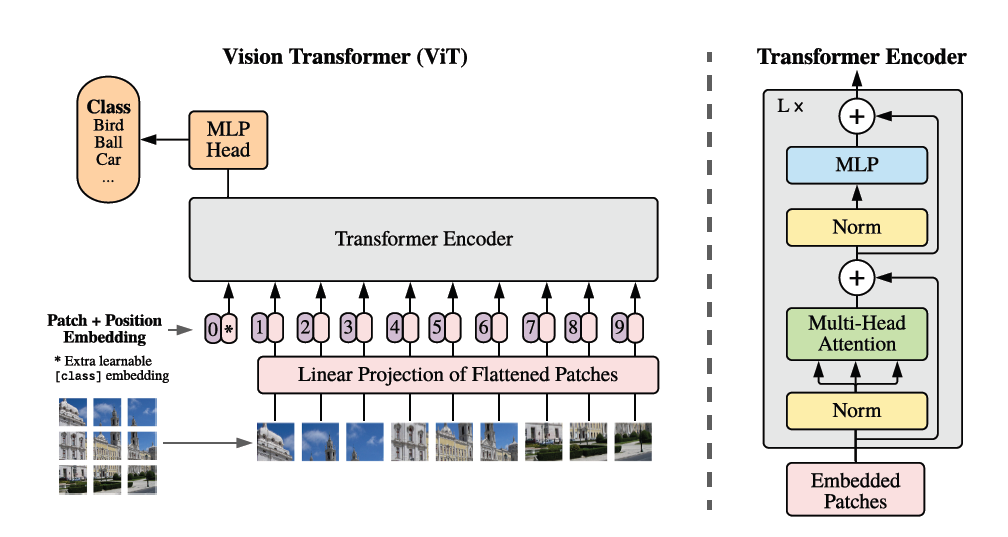

Figure 1: Model overview. We split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, we use the standard approach of adding an extra learnable “classification token” to the sequence

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image x 2 RHWC into a sequence of flattened 2D patches xp 2 RN(P2C), where (H;W) is the resolution of the original image, C is the number of channels, (P, P) is the resolution of each image patch, and N = HW/P**2 is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

**Datasets**

This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package
https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

The paper for dataset is [Lung and Colon Cancer Histopathological Image Dataset (LC25000)](https://arxiv.org/abs/1912.12142v1)

There are five classes in the dataset, each with 5,000 images, being:

*   Lung benign tissue
*   Lung adenocarcinoma
*   Lung squamous cell carcinoma
*   Colon adenocarcinoma
*   Colon benign tissue


In [ ]:
!unzip /content/drive/MyDrive/LungColonData.zip

Archive:  /content/drive/MyDrive/LungColonData.zip
replace LungColonData/test/colon_adenocarcinoma/colonca4501.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
from torch import nn
from torchvision import transforms

In [ ]:
!unzip /content/drive/MyDrive/helpermodules.zip

Archive:  /content/drive/MyDrive/helpermodules.zip
replace going_modular/data_setup.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
# Setup directory paths to train and test images
train_dir = "LungColonData/train"
test_dir = "LungColonData/test"

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78ded2862e30>,
 ['colon_adenocarcinoma',
  'colon_normal',
  'lung_adenocarcinoma',
  'lung_normal',
  'lung_squamouscellcarcinoma'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

Visualize a single image

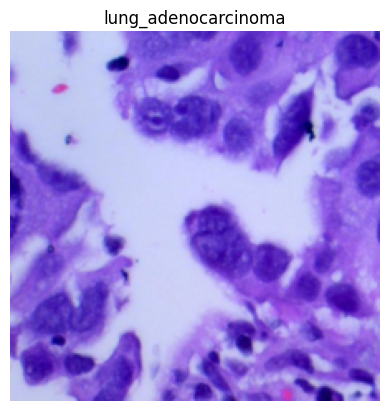

In [ ]:
# Plot image with matplotlib
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])
image = image* STD[:, None, None] + MEAN[:, None, None]  #denormalize to display the image in matplotlib

plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Now we've got some data, let's now turn it into DataLoader's.

To do so we can use the create_dataloaders() function in data_setup.py.

First, we'll create a transform to prepare our images.

This where one of the first references to the ViT paper will come in.([An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929))

In Table 3, the training resolution is mentioned as being 224 (height=224, width=224).

The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32).

However, we're going to stick with a batch size of 32.
Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096.

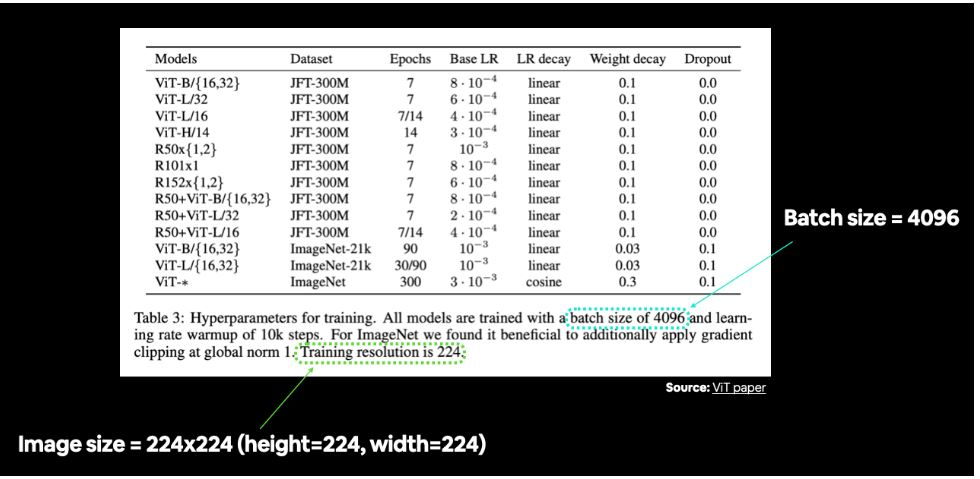

In [ ]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


The ViT architecture is comprised of several stages:

*Patch + Position Embedding (inputs)* - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.

*Norm* - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().

*Multi-Head Attention* - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().

*MLP (or Multilayer perceptron)* - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendex B.1).

*Transformer Encoder* - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.

*MLP Head *- This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.
You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

Figure 1: Model overview. We split an image into fixed-size patches, linearly embed each of them,
add position embeddings, and feed the resulting sequence of vectors to a standard Transformer
encoder. In order to perform classification, we use the standard approach of adding an extra learnable
“classification token” to the sequence


An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D
sequence of token embeddings. To handle 2D images, we reshape the image x 2 RHWC into a
sequence of flattened 2D patches xp 2 RN(P2C), where (H;W) is the resolution of the original
image, C is the number of channels, (P, P) is the resolution of each image patch, and N = HW/P**2
is the resulting number of patches, which also serves as the effective input sequence length for the
Transformer.

Exploring the Four Equations
The next main part(s) of the ViT paper we're going to look at are the four equations

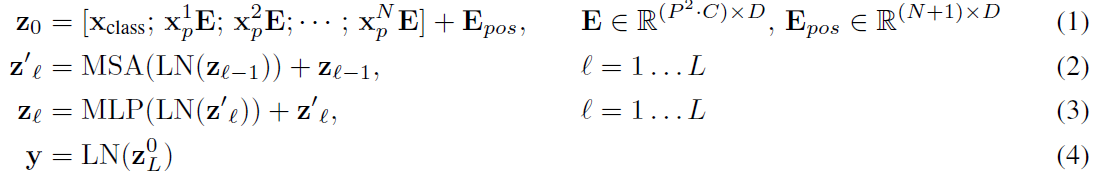

These four equations represent the math behind the four major parts of the ViT architecture.

In [ ]:
#Input embedding layer  shape
embedding_layer_input_shape  = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


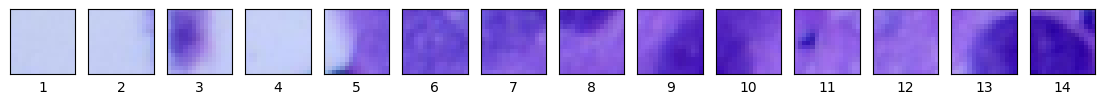

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


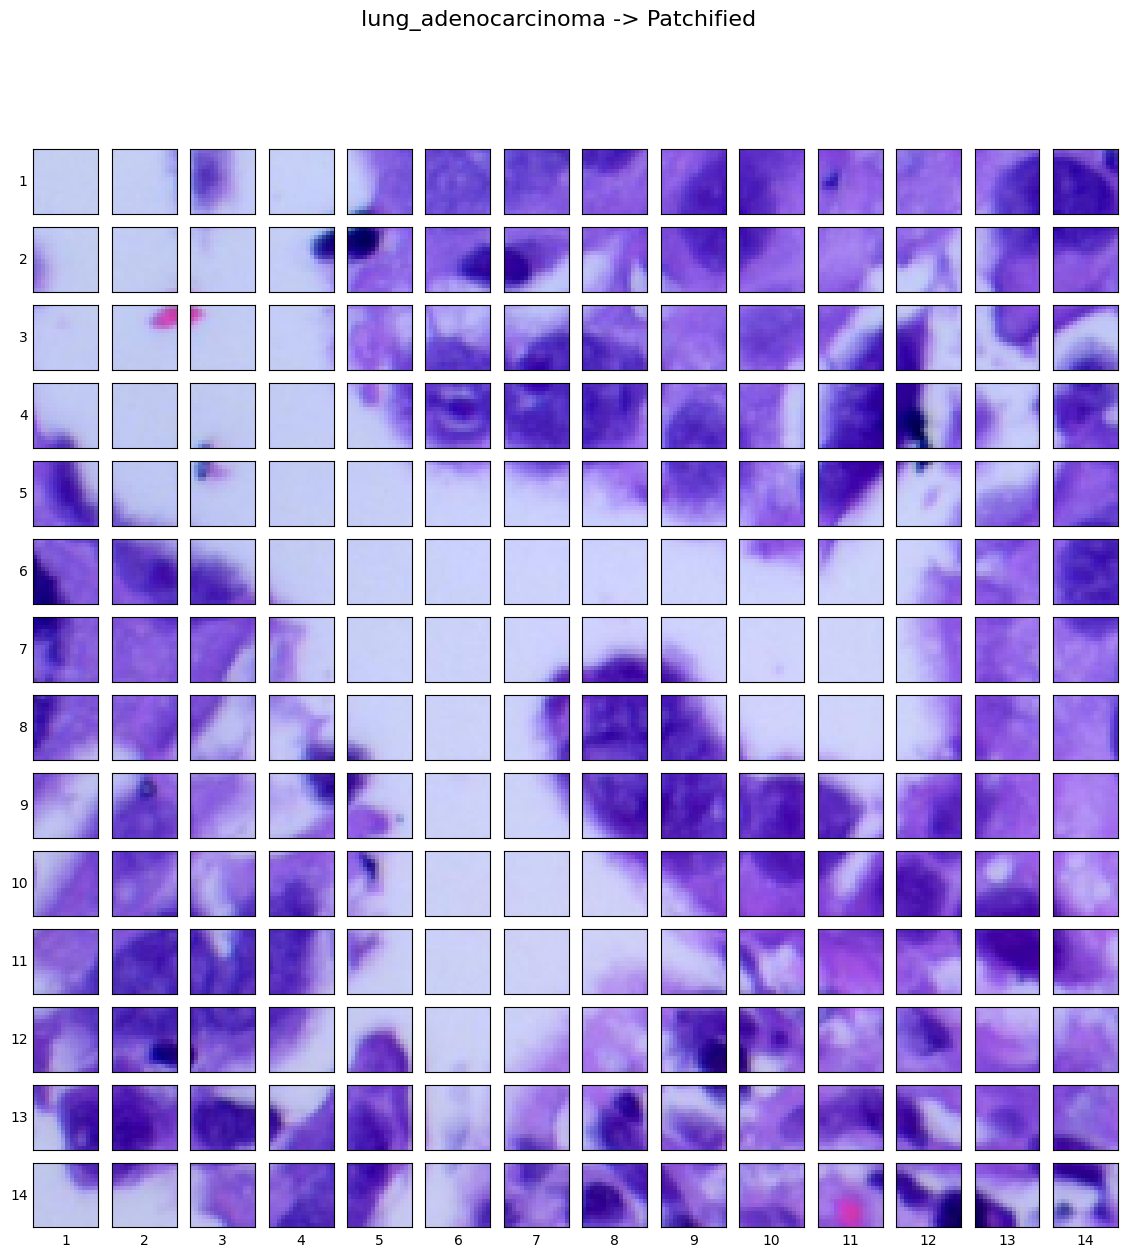

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [ ]:
#Creating patches and turning them into patch embeddings
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

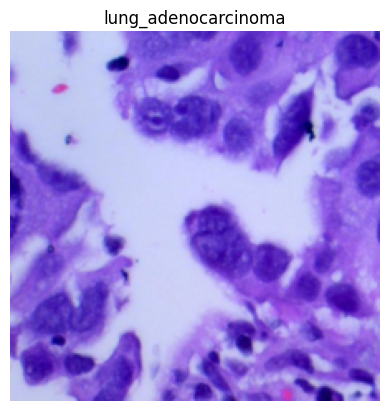

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


So its output shape can be read as:

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width] Let's visualize five random feature maps and see what they look like.

Showing random feature maps from indexes: [735, 553, 489, 218, 329]


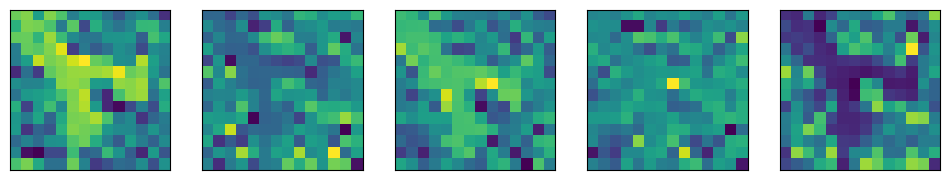

In [ ]:
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random feature maps from indexes: {random_indexes}")

#create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
      image_conv_feature_map = image_out_of_conv[:, idx, :, :]
      axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
      axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-1.0276, -1.0119, -0.7118, -1.0401, -0.8629, -0.5644, -0.5594,
           -0.5603, -0.6366, -0.5020, -0.6094, -0.6791, -0.6479, -0.3477],
          [-0.9580, -1.0211, -0.9815, -0.9625, -0.3290, -0.6556, -0.6511,
           -0.6886, -0.5983, -0.4910, -0.8165, -0.6358, -0.8105, -0.4987],
          [-0.9980, -1.0330, -0.9339, -0.9919, -0.7930, -0.7872, -0.8092,
           -0.7131, -0.7796, -0.6186, -0.5764, -0.8596, -0.8424, -0.7018],
          [-0.9922, -1.0064, -1.0188, -1.0186, -0.8559, -0.4632, -0.4752,
           -0.4405, -0.6998, -0.7014, -0.6751, -0.5424, -0.8850, -0.4941],
          [-0.4555, -0.9862, -0.9126, -1.0236, -1.0270, -0.9693, -0.9312,
           -0.8413, -0.5802, -0.6726, -0.6048, -0.8857, -0.8937, -0.6102],
          [-0.6009, -0.4995, -0.7615, -1.0213, -1.0316, -1.0547, -1.0644,
           -1.0818, -1.0595, -0.9273, -0.9294, -0.9552, -0.7896, -0.5263],
          [-0.4796, -0.6616, -0.6960, -0.8830, -1.0457, -1.0585, -1.0369,
           -0.9816, -1.1075, -1.

We've turned our image into patch embeddings but they're still in 2D format. Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -(N x P^2 *C)

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


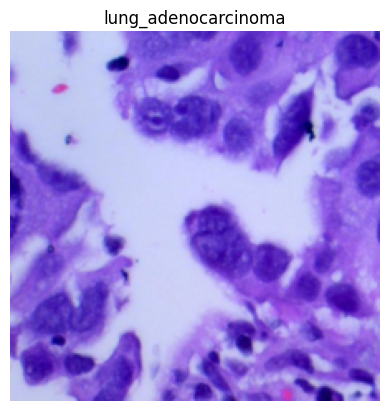

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
#Current shape: (1, 768, 196)
#We can fix the diemnsions using permute
image_out_of_conv_flattened_reshaped  = image_out_of_conv_flattened.permute(0,2,1) # [batch_size, P^2•C, N]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


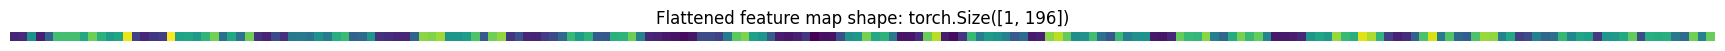

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
#Turning the ViT patch embedding layer into a PyTorch module

class PatchEmbedding(nn.Module):

    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

         # 3. Create a layer to turn an image into patches

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        #Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                 end_dim=3)

        #Define the forward method

    def forward(self, x):
         # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)
# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)

#Display the first 10 class tokens
print(class_token[:, :, :10])

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding  = torch.cat((class_token, patch_embedded_image), dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8382,  0.2518, -0.2518,  ...,  0.6706, -0.3718,  0.2860],
         [-0.7984,  0.1970, -0.2758,  ...,  0.6521, -0.3322,  0.2872],
         ...,
         [-0.3320,  0.0841,  0.0072,  ...,  0.2755, -0.2484,  0.0958],
         [-0.7882,  0.1758, -0.1403,  ...,  0.5408, -0.2141,  0.0461],
         [-0.5573,  0.2986, -0.2606,  ...,  0.3301, -0.1354,  0.3458]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
#Calculate the number of patches N
number_of_patches = (height * width) // (patch_size ** 2)
number_of_patches

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

#Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                 requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
#Concatenate the patch embedding with position embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.1618, 1.2518, 0.7482,  ..., 1.6706, 0.6282, 1.2860],
          [0.2016, 1.1970, 0.7242,  ..., 1.6521, 0.6678, 1.2872],
          ...,
          [0.6680, 1.0841, 1.0072,  ..., 1.2755, 0.7516, 1.0958],
          [0.2118, 1.1758, 0.8597,  ..., 1.5408, 0.7859, 1.0461],
          [0.4427, 1.2986, 0.7394,  ..., 1.3301, 0.8646, 1.3458]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

Putting it all together. We have turned an image into flattened sequence of patches with embeddings plus position embedding *EQUATION #1

In [ ]:
set_seeds()

patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

#6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True) # This should be learnable parameter
print(f"class token embedding shape: {class_token.shape}")

#7. Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1) #across the first dimension which is 196
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

#8. Create Position embedding
number_of_patches = (height * width) // (patch_size ** 2)

position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                 requires_grad=True)

#10. Add position embedding to patch embedding with class token
patch_and_position_embedding  = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape torch.Size([1, 197, 768])


**EQUATION 2 : Multihead Self Attention**

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):

    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout:int=0):
        super().__init__()

        #Create Layernorm
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        #Create MSA
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output


The above code highlights the triple embedding input to the MSA layer.

This is known as query, key, value input or qkv for short which is fundamental to the self-attention mechanism.

In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value.

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA {patch_and_position_embedding.shape}")
print(f"Output shape of MSA {patched_image_through_msa_block.shape}")

Input shape of MSA torch.Size([1, 197, 768])
Output shape of MSA torch.Size([1, 197, 768])


**EQUATION 3 MLP Block**

In [ ]:
class MLPBlock(nn.Module):

    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072, #based on Table 3 of ViT paper
                dropout:float=0.1):
        super().__init__()

        #Create a layernorm
        self.layernorm = nn.LayerNorm(normalized_shape=embedding_dimension)

        #Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                         out_features=mlp_size),
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size,
                         out_features=embedding_dim),
                nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layernorm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

#pass output of MSA Block through MLP Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block

tensor([[[-0.3047, -0.2016,  0.1568,  ..., -0.5489,  0.9423, -0.6063],
         [-0.3066, -0.1993,  0.1645,  ..., -0.5472,  0.9500, -0.6080],
         [-0.3068, -0.1989,  0.1645,  ..., -0.5471,  0.9499, -0.6079],
         ...,
         [-0.3069, -0.2011,  0.1677,  ..., -0.5468,  0.9506, -0.6100],
         [-0.3093, -0.2008,  0.1634,  ..., -0.5467,  0.9502, -0.6052],
         [-0.3065, -0.2001,  0.1638,  ..., -0.5473,  0.9487, -0.6077]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp_block

tensor([[[-0.1101,  0.0324, -0.0278,  ...,  0.0000, -0.1209,  0.0894],
         [-0.1614, -0.0760,  0.0442,  ..., -0.0996, -0.1035,  0.1446],
         [-0.1268, -0.0154,  0.0675,  ..., -0.0000, -0.1575,  0.1227],
         ...,
         [-0.2882,  0.0424,  0.0436,  ...,  0.1429, -0.1524,  0.1935],
         [-0.2464,  0.0694, -0.0000,  ...,  0.0753, -0.1480,  0.0410],
         [-0.1313, -0.0022, -0.0260,  ..., -0.0462, -0.1462,  0.1304]]],
       grad_fn=<MulBackward0>)

**Residual connection**
input -> MSA block ->[MSA block output + input] ->MLP block ->[MLP block output + MSA block output + input] ->....
# Complete Transformer Encoder

In [ ]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:float=0.1,
                attn_dropout:float=0):
        super().__init__()

        #Create a MSA block
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)

        #Create MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                 mlp_size=mlp_size,
                                 dropout=mlp_dropout)

    def forward(self, x):
        #Create residual connection for MSA block (add the input to the output)
        x = self.msa_block(x) + x

        #Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

In [ ]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
# summary(model=torch_transformer_encoder_layer,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

**Putting everything together**

In [ ]:
class ViT(nn.Module):

    def __init__(self,
                imagesize:int=224,
                in_channels:int=3,
                patch_size:int=16,
                num_transformer_layers:int=12,
                embedding_dim:int=768,
                mlp_size:int=3072,
                num_heads:int=12,
                attn_dropout:int=0,
                mlp_dropout:float=0.1,
                embedding_dropout:float=0.1,
                num_classes:int=1000): #number of classes for classification
        super().__init__()

        # Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                            requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)

        # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
            # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

      # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):

        batch_size = x.shape[0]

        #Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        #Create position embedding
        x = self.position_embedding + x

        # Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


Let's create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens.

In [ ]:
set_seeds()

random_image_tensor  = torch.randn(1,3,224,224)

# Create an instance of ViT with the number of classes we're working (3)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.1234,  0.8412,  1.3322, -0.1883, -0.4334]],
       grad_fn=<AddmmBackward0>)

In [ ]:
class_names

['colon_adenocarcinoma',
 'colon_normal',
 'lung_adenocarcinoma',
 'lung_normal',
 'lung_squamouscellcarcinoma']

In [ ]:
# from torchinfo import summary

# summary(model = ViT(num_classes=len(class_names)),
#        input_size=(1,3,224,224),
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

Create a Adam Optimizer and Loss function (Cross Entropy as this is multiclasss classification)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.AdamW(params=vit.parameters(),
                             lr=1e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=1e-2) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6680 | train_acc: 0.6976 | test_loss: 0.5322 | test_acc: 0.7750
Epoch: 2 | train_loss: 0.5050 | train_acc: 0.7678 | test_loss: 0.4720 | test_acc: 0.7946
Epoch: 3 | train_loss: 0.4663 | train_acc: 0.7881 | test_loss: 0.5316 | test_acc: 0.7422
Epoch: 4 | train_loss: 0.4783 | train_acc: 0.7777 | test_loss: 0.4718 | test_acc: 0.7783
Epoch: 5 | train_loss: 0.4601 | train_acc: 0.7868 | test_loss: 0.4712 | test_acc: 0.7564
Epoch: 6 | train_loss: 0.4434 | train_acc: 0.7937 | test_loss: 0.4653 | test_acc: 0.7699
Epoch: 7 | train_loss: 0.4506 | train_acc: 0.7926 | test_loss: 0.4266 | test_acc: 0.8050
Epoch: 8 | train_loss: 0.4316 | train_acc: 0.8077 | test_loss: 0.4032 | test_acc: 0.8197
Epoch: 9 | train_loss: 0.4278 | train_acc: 0.8089 | test_loss: 0.5084 | test_acc: 0.7442
Epoch: 10 | train_loss: 0.4059 | train_acc: 0.8187 | test_loss: 0.3908 | test_acc: 0.8217


**Plot the train and test loss**

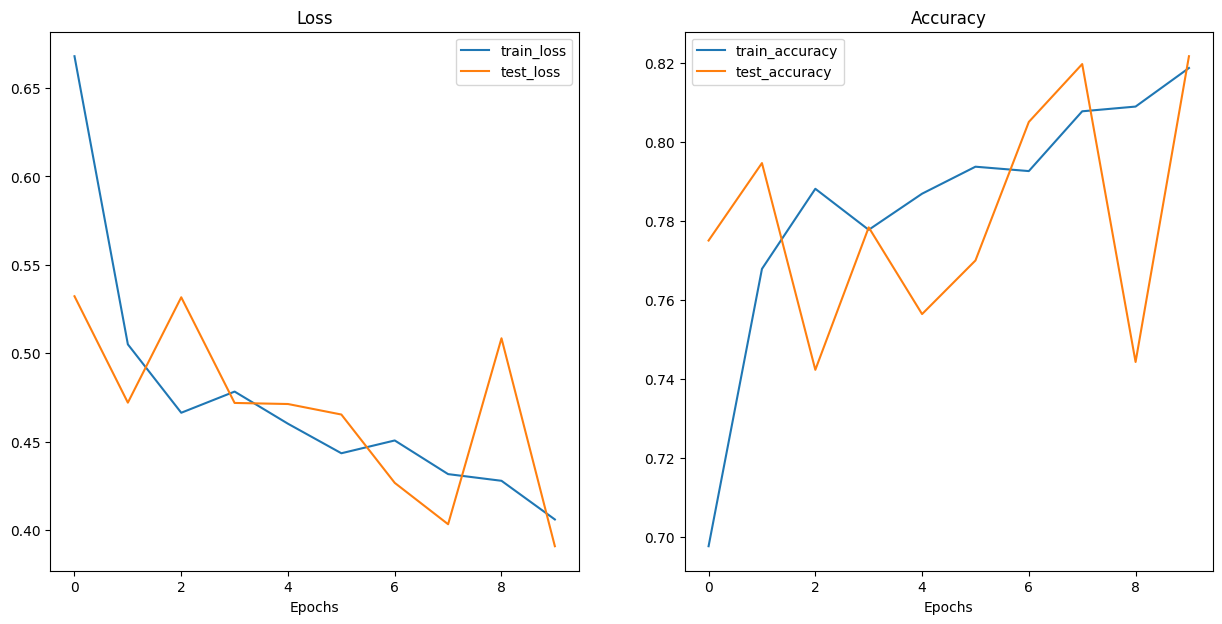

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

The curves don't seem to follow the standard curves since we do not have large datasets like imagenet. Transformers have a large capacity for learning, the more the data the better the learning. Let's use the pretrained VIT_B_16 (Base model) and see the results.

In [ ]:
#Save the best performance VIT model
from going_modular import utils

utils.save_model(model=vit,
                target_dir="models",
                model_name="vit_orig_model_lungcoloncancer.pth")

[INFO] Saving model to: models/vit_orig_model_lungcoloncancer.pth


# **Using Pretained ViT Model**

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 106MB/s]


In [ ]:
#Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 5]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3) # Base LR from Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1518 | train_acc: 0.9554 | test_loss: 0.0856 | test_acc: 0.9657
Epoch: 2 | train_loss: 0.0655 | train_acc: 0.9777 | test_loss: 0.0559 | test_acc: 0.9817
Epoch: 3 | train_loss: 0.0489 | train_acc: 0.9845 | test_loss: 0.0490 | test_acc: 0.9826
Epoch: 4 | train_loss: 0.0417 | train_acc: 0.9862 | test_loss: 0.0439 | test_acc: 0.9854
Epoch: 5 | train_loss: 0.0374 | train_acc: 0.9873 | test_loss: 0.0376 | test_acc: 0.9882
Epoch: 6 | train_loss: 0.0316 | train_acc: 0.9895 | test_loss: 0.0439 | test_acc: 0.9831
Epoch: 7 | train_loss: 0.0284 | train_acc: 0.9905 | test_loss: 0.0336 | test_acc: 0.9879
Epoch: 8 | train_loss: 0.0262 | train_acc: 0.9909 | test_loss: 0.0329 | test_acc: 0.9910
Epoch: 9 | train_loss: 0.0252 | train_acc: 0.9908 | test_loss: 0.0349 | test_acc: 0.9883
Epoch: 10 | train_loss: 0.0225 | train_acc: 0.9929 | test_loss: 0.0277 | test_acc: 0.9902


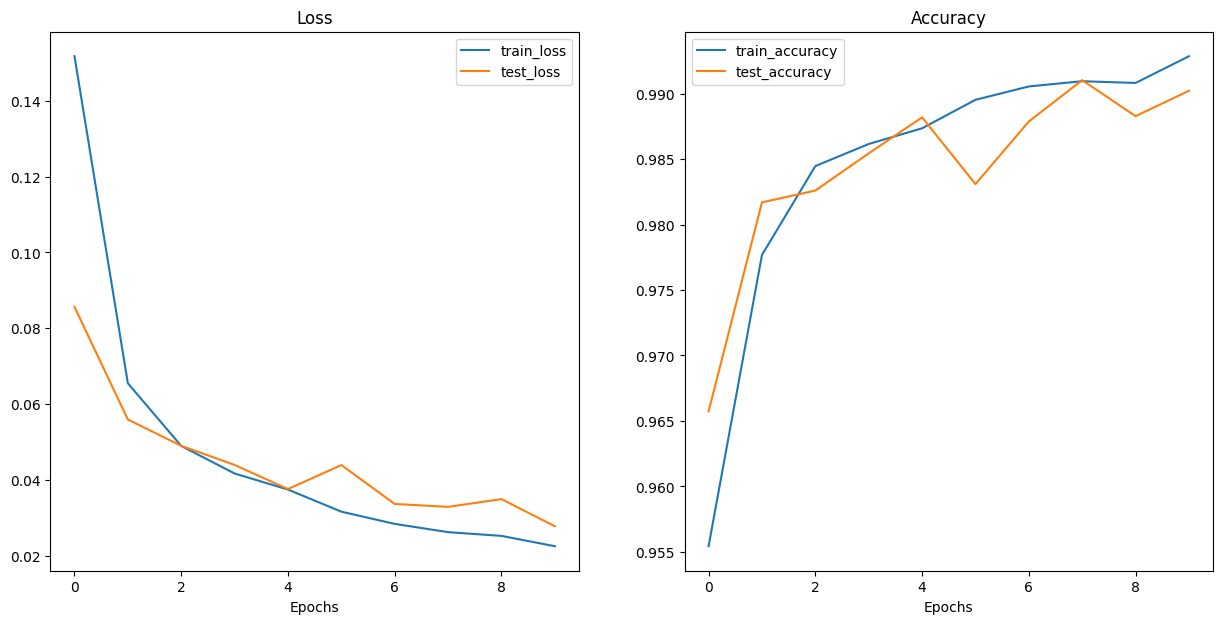

In [ ]:
plot_loss_curves(results)

As the results show the pretrained model outperforms the one we trained with small data for the model which was built from scratch.

In [ ]:
#Save the best performance VIT model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                target_dir="models",
                model_name="pretrained_vit_model_lungcoloncancer.pth")


[INFO] Saving model to: models/pretrained_vit_model_lungcoloncancer.pth


# Make predictions on a custom image:
Let's us take few samples of real data and see how it performs.

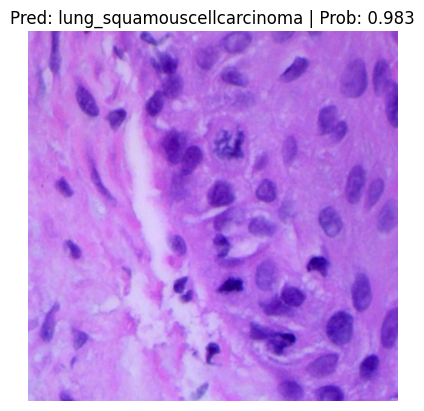

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
image_path = "/content/drive/MyDrive/TestSamples"
custom_image_path = image_path + "/" + "lungscc4997.jpeg"

# Download the image if it doesn't already exist
# if not custom_image_path.is_file():
#     with open(custom_image_path, "wb") as f:
#         # When downloading from GitHub, need to use the "raw" file link
#         request = requests.get("https://raw.githubusercontent.com/....")
#         print(f"Downloading {custom_image_path}...")
#         f.write(request.content)
# else:
#     print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import pathlib
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpeg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpeg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpeg' in directory: LungColonData/test


[PosixPath('LungColonData/test/lung_normal/lungn4791.jpeg'),
 PosixPath('LungColonData/test/lung_normal/lungn4576.jpeg'),
 PosixPath('LungColonData/test/lung_normal/lungn4717.jpeg'),
 PosixPath('LungColonData/test/lung_normal/lungn4806.jpeg'),
 PosixPath('LungColonData/test/lung_normal/lungn4543.jpeg')]

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

In [ ]:
# 1. Create a function to return a list of dictionaries with samples, ground truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=pretrained_vit,
                                     transform=pretrained_vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/2450 [00:00<?, ?it/s]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     2429
False      21
Name: correct, dtype: int64

**Plot the Confusion Matrix**

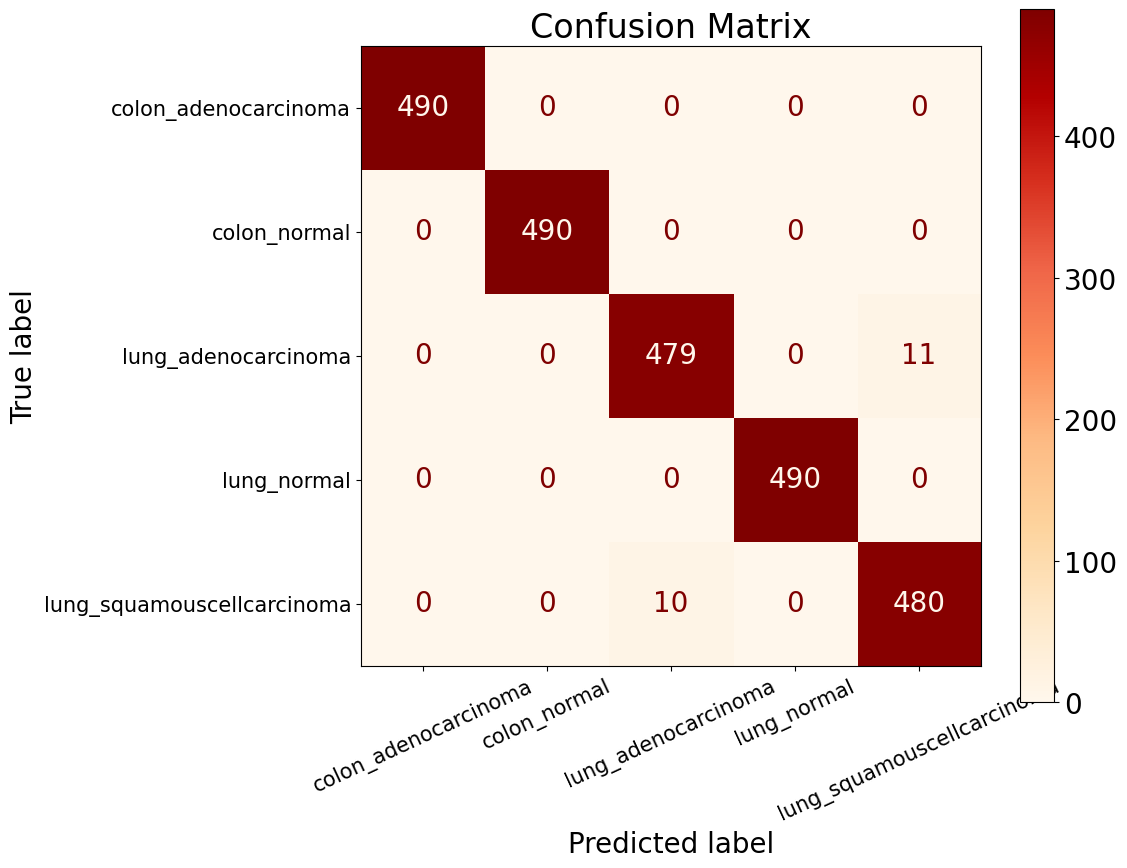

In [ ]:
#display the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

c_m = confusion_matrix(vit_test_pred_df['class_name'], vit_test_pred_df['pred_class'])
# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=class_names)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Show the plot
plt.show()

**Now let us see how the current state of art EfficientNet B7 ConvNet works and see the performance with ViT**

**Creating an EffNetB7 feature extractor**

In [ ]:
# 1. Setup pretrained EffNetB2 weights
effnetb7_weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb7_transforms = effnetb7_weights.transforms()

# 3. Setup pretrained model
effnetb7 = torchvision.models.efficientnet_b7(weights=effnetb7_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb7.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:15<00:00, 17.2MB/s]


In [ ]:
# Check out EffNetB2 classifier head
effnetb7.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head to predict the five classes
effnetb7.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=5)) # change out_features to suit our number of classes

In [ ]:
def create_effnetb7_model(num_classes:int=5,
                          seed:int=42):
    """Creates an EfficientNetB7 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 5.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b7(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=2560, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb7, effnetb7_transforms = create_effnetb7_model(num_classes=5,
                                                      seed=42)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb7,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 2560, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 64, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 64, 112, 112]    (1,728)              False
│    │    └─BatchNorm2d (1)                                  [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    │    └─SiLU (2)                                         [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 64, 112, 112]    [1, 3

**Creating DataLoaders for EffNetB7**

In [ ]:
# Setup DataLoaders
from going_modular import data_setup
train_dataloader_effnetb7, test_dataloader_effnetb7, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb7_transforms,
                                                                                                 batch_size=32)

**Training EffNet B7**

In [ ]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb7.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb7_results = engine.train(model=effnetb7,
                                train_dataloader=train_dataloader_effnetb7,
                                test_dataloader=test_dataloader_effnetb7,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device="cuda")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2317 | train_acc: 0.9446 | test_loss: 0.0710 | test_acc: 0.9843
Epoch: 2 | train_loss: 0.1034 | train_acc: 0.9658 | test_loss: 0.0499 | test_acc: 0.9863
Epoch: 3 | train_loss: 0.0889 | train_acc: 0.9691 | test_loss: 0.0424 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.0808 | train_acc: 0.9716 | test_loss: 0.0366 | test_acc: 0.9916
Epoch: 5 | train_loss: 0.0748 | train_acc: 0.9743 | test_loss: 0.0338 | test_acc: 0.9894
Epoch: 6 | train_loss: 0.0673 | train_acc: 0.9755 | test_loss: 0.0328 | test_acc: 0.9899
Epoch: 7 | train_loss: 0.0671 | train_acc: 0.9759 | test_loss: 0.0307 | test_acc: 0.9899
Epoch: 8 | train_loss: 0.0693 | train_acc: 0.9749 | test_loss: 0.0279 | test_acc: 0.9932
Epoch: 9 | train_loss: 0.0671 | train_acc: 0.9755 | test_loss: 0.0286 | test_acc: 0.9908
Epoch: 10 | train_loss: 0.0648 | train_acc: 0.9744 | test_loss: 0.0271 | test_acc: 0.9912


**Inspecting EffNetB2 loss curves**

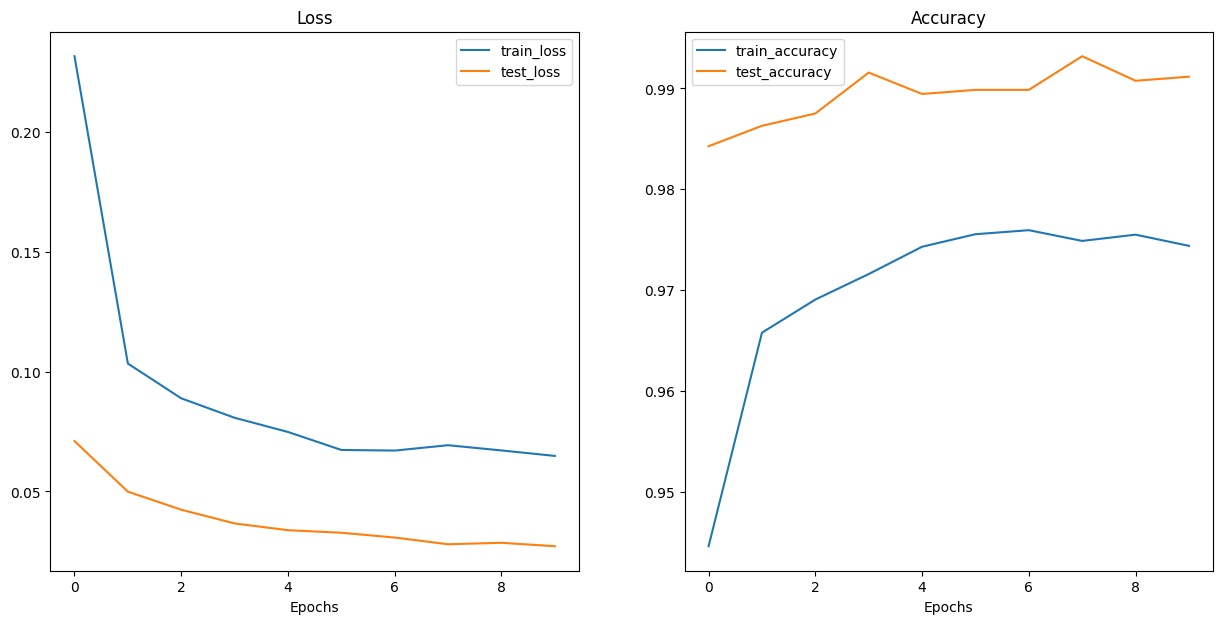

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb7_results)

In [ ]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetb7,
                 target_dir="models",
                 model_name="pretrained_effnetb7_LungColonDetector.pth")

[INFO] Saving model to: models/pretrained_effnetb7_LungColonDetector.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb7_model_size = Path("models/pretrained_effnetb7_LungColonDetector.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB7 feature extractor model size: {pretrained_effnetb7_model_size} MB")

Pretrained EffNetB7 feature extractor model size: 245 MB


**Feature Statistics**

In [ ]:
# Count number of parameters in EffNetB7
effnetb7_total_params = sum(torch.numel(param) for param in effnetb7.parameters())
effnetb7_total_params

63799765

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb7_stats = {"test_loss": effnetb7_results["test_loss"][-1],
                  "test_acc": effnetb7_results["test_acc"][-1],
                  "number_of_parameters": effnetb7_total_params,
                  "model_size (MB)": pretrained_effnetb7_model_size}
effnetb7_stats

{'test_loss': 0.027124969105555806,
 'test_acc': 0.9911616161616161,
 'number_of_parameters': 63799765,
 'model_size (MB)': 245}

**Check on real data**

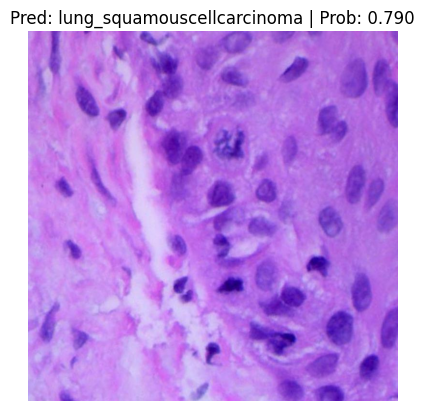

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
image_path = "/content/drive/MyDrive/TestSamples"
custom_image_path = image_path + "/" + "lungscc4997.jpeg"

# Download the image if it doesn't already exist
# if not custom_image_path.is_file():
#     with open(custom_image_path, "wb") as f:
#         # When downloading from GitHub, need to use the "raw" file link
#         request = requests.get("https://raw.githubusercontent.com/....")
#         print(f"Downloading {custom_image_path}...")
#         f.write(request.content)
# else:
#     print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=effnetb7,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import pathlib
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpeg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpeg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpeg' in directory: LungColonData/test


[PosixPath('LungColonData/test/colon_adenocarcinoma/colonca4759.jpeg'),
 PosixPath('LungColonData/test/colon_adenocarcinoma/colonca4919.jpeg'),
 PosixPath('LungColonData/test/colon_adenocarcinoma/colonca4774.jpeg'),
 PosixPath('LungColonData/test/colon_adenocarcinoma/colonca4964.jpeg'),
 PosixPath('LungColonData/test/colon_adenocarcinoma/colonca4634.jpeg')]

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
effnetb7_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=effnetb7,
                                     transform=effnetb7_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/2450 [00:00<?, ?it/s]

In [ ]:
# Turn effnetB7_test_pred_dicts into a DataFrame
import pandas as pd
effnetb7_test_pred_df = pd.DataFrame(effnetb7_test_pred_dicts)
effnetb7_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,LungColonData/test/colon_adenocarcinoma/colonc...,colon_adenocarcinoma,0.9998,colon_adenocarcinoma,2.9313,True
1,LungColonData/test/colon_adenocarcinoma/colonc...,colon_adenocarcinoma,1.0000,colon_adenocarcinoma,4.9394,True
2,LungColonData/test/colon_adenocarcinoma/colonc...,colon_adenocarcinoma,0.9997,colon_adenocarcinoma,2.3056,True
3,LungColonData/test/colon_adenocarcinoma/colonc...,colon_adenocarcinoma,0.9999,colon_adenocarcinoma,2.4090,True
4,LungColonData/test/colon_adenocarcinoma/colonc...,colon_adenocarcinoma,1.0000,colon_adenocarcinoma,2.5147,True


In [ ]:
# Count the number of correct predictions
effnetb7_test_pred_df.correct.value_counts()

True     2429
False      21
Name: correct, dtype: int64

**Plot the Confusion Matrix**

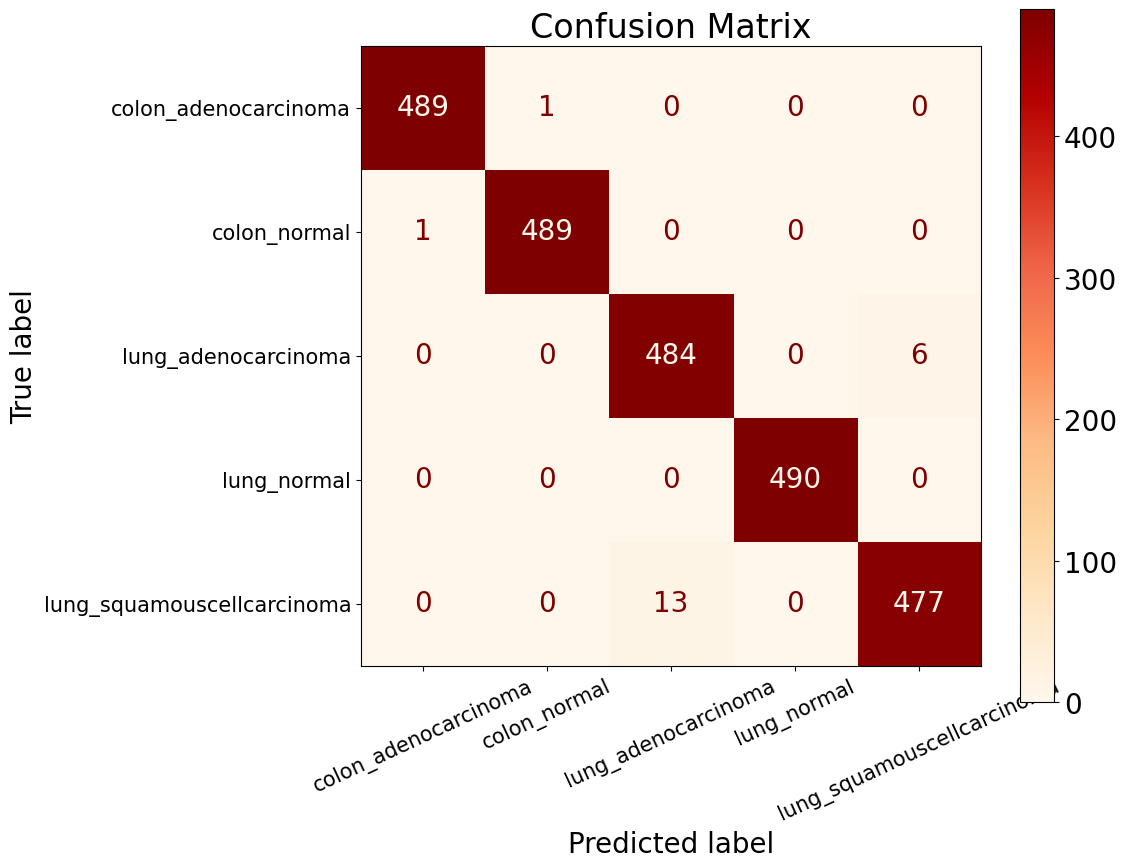

In [ ]:
#display the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

c_m = confusion_matrix(effnetb7_test_pred_df['class_name'], effnetb7_test_pred_df['pred_class'])
# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=class_names)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Show the plot
plt.show()

# **Summary of both models with accuracy count and metric:**

**ViT Model**

Number of correct predictions : 2429

Number of incorrect predictions : 21

Training and Test Accuracy :
Epoch: 10 | train_loss: 0.0225 | train_acc: 0.9929 | test_loss: 0.0277 | test_acc: 0.9902

**EfficientNet B7 Model**


Count the number of correct predictions

Number of correct predictions : 2429

Number of incorrect predictions : 21

Training and Test Accuracy :
Epoch: 10 | train_loss: 0.0648 | train_acc: 0.9744 | test_loss: 0.0271 | test_acc: 0.9912


**Acronynms:**

MSA: Multihead Self Attention

MLP: Multilayer Perceptron

LN: Layer Normalization

Vit: Vision Transformer

# References:

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
Łukasz Kaiser, and Illia Polosukhin. Attention is all you need. In NIPS, 2017.

Y. LeCun, B. Boser, J. Denker, D. Henderson, R. Howard, W. Hubbard, and L. Jackel. Backpropagation
applied to handwritten zip code recognition. Neural Computation, 1:541–551, 1989

Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition.
In CVPR, 2016.


#Conclusion and Future work


---


We have explored the direct application of Transformers to image recognition. Unlike prior works
using self-attention in computer vision, we do not introduce image-specific inductive biases into
the architecture apart from the initial patch extraction step. Instead, we interpret an image as a
sequence of patches and process it by a standard Transformer encoder as used in NLP. This simple,
yet scalable, strategy works surprisingly well when coupled with pre-training on large datasets.
Thus, Vision Transformer matches or exceeds the state of the art on many image classification
datasets.

In future, i will look into other transformer based architecture like the Swin Transformers which seem to show better computational efficiency as compared to Vision Transformer(ViT).